In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline

from itertools import combinations

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

In [2]:
def hamming_distance(s1, s2):
#     print(s1,s2)
    assert len(s1) == len(s2)
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

In [3]:

condition = 'Evo1D_IRAs'
reps = [1,2]
timepoints = [0,1,4,7,10,13,16,19,22,24]

# condition = 'Evo1D_TCG'
# reps = [1,2]
# timepoints = [0,1,4,8,10,13,16,19,22,24]


# condition = 'Evo2D_Ira1_Mis'
# # condition = 'Evo2D_Ira1_Non'
# reps = [1,2]
# timepoints = [0,1,4,7,10,13]

# condition = 'Evo3D_Ira1_Mis'
# condition = 'Evo3D_Ira1_Non'
# reps = [1,2,3]
# timepoints = [0,1,4,7,10]

# condition = 'Evo3D_TCG'
# reps = [1,2]
# timepoints = [0,1,4,7,10]



all_samples = []
for time in timepoints:
    if time == 0:
        all_samples.append(f'{condition}_0_0')
    else:
        for rep in reps:
            all_samples.append(f'{condition}_{rep}_{time}')


In [4]:
all_samples

['Evo1D_IRAs_0_0',
 'Evo1D_IRAs_1_1',
 'Evo1D_IRAs_2_1',
 'Evo1D_IRAs_1_4',
 'Evo1D_IRAs_2_4',
 'Evo1D_IRAs_1_7',
 'Evo1D_IRAs_2_7',
 'Evo1D_IRAs_1_10',
 'Evo1D_IRAs_2_10',
 'Evo1D_IRAs_1_13',
 'Evo1D_IRAs_2_13',
 'Evo1D_IRAs_1_16',
 'Evo1D_IRAs_2_16',
 'Evo1D_IRAs_1_19',
 'Evo1D_IRAs_2_19',
 'Evo1D_IRAs_1_22',
 'Evo1D_IRAs_2_22',
 'Evo1D_IRAs_1_24',
 'Evo1D_IRAs_2_24']

In [5]:
sample_dict = {}

for sample in all_samples:
    sample_dict[sample] = p.read_table(f'{condition}/{sample}/cluster_final.txt',names=['pair_name','high_diversity_BC','low_diversity_BC',f'{sample}_count'])
    sample_dict[sample]['fused_bc'] = sample_dict[sample]['low_diversity_BC'] +'_'+ sample_dict[sample]['high_diversity_BC']
    sample_dict[sample] = sample_dict[sample].drop(columns=['pair_name'])

In [6]:
merged_samples = sample_dict[all_samples[0]]

for sample in all_samples[1:]:
    merged_samples = merged_samples.merge(sample_dict[sample],'outer',on=['fused_bc','high_diversity_BC','low_diversity_BC'])





In [7]:
def logit(x):
    
    return np.log(x/(1-x))

In [8]:
cutoff = 10
nonzero = 5

count_cols = [col for col in merged_samples if 'count' in col]

cutoff_merged = merged_samples[np.any(merged_samples[count_cols]>cutoff,axis=1)]

cutoff_merged = cutoff_merged.fillna(0)

cutoff_merged = cutoff_merged[np.count_nonzero(cutoff_merged[count_cols],axis=1)>nonzero]

In [9]:
rep = 1
coverage_cutoff = 100000
these_timepoints = timepoints

these_times = [f'{condition}_{rep}_{time}_count' for time in these_timepoints if time != 0]
these_times = [f'{condition}_0_0_count'] + these_times

these_counts = cutoff_merged[these_times].values


these_freqs = these_counts/np.nansum(these_counts,axis=0)


low_coverage = np.where(np.nansum(these_counts,axis=0)<coverage_cutoff)[0]

these_freqs = np.delete(these_freqs,low_coverage,axis=1)
these_freqs = these_freqs[np.all(these_freqs>0,axis=1)]
these_times = np.delete(these_times,low_coverage)
these_timepoints = np.delete(these_timepoints,low_coverage)

In [10]:
nonzeros = these_freqs[np.all(these_freqs>0,axis=1)]

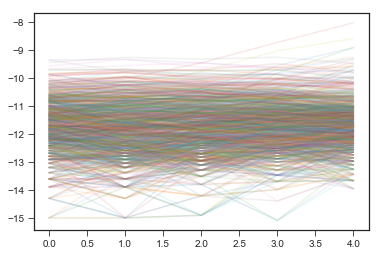

In [13]:
n_lineages = 1000

plt.plot(logit(nonzeros)[:n_lineages,:5].swapaxes(0,1),alpha=0.1)

In [17]:
logit(nonzeros)[:,0].shape

(64760,)

In [23]:
np.diff(logit(nonzeros))[:,0].shape

(64760,)

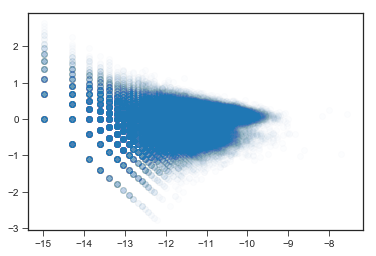

In [29]:


plt.scatter(logit(nonzeros)[:,0],np.diff(logit(nonzeros))[:,0],alpha=0.01)

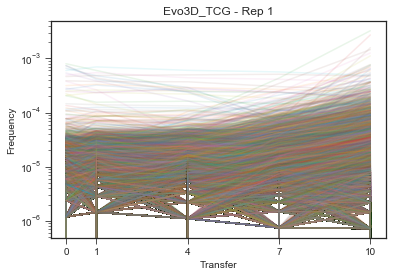

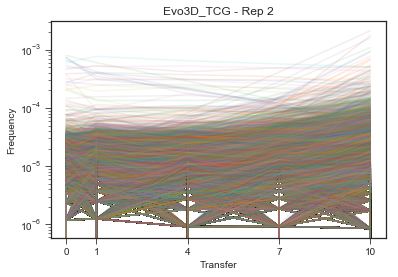

In [48]:
coverage_cutoff = 1e5

for rep in reps:
    exclude_times = []
    these_timepoints = [time for time in timepoints if time not in exclude_times]

    these_times = [f'{condition}_{rep}_{time}_count' for time in these_timepoints if time != 0]
    these_times = [f'{condition}_0_0_count'] + these_times

    these_counts = cutoff_merged[these_times].values
    

    these_freqs = these_counts/np.nansum(these_counts,axis=0)
    
    
    low_coverage = np.where(np.nansum(these_counts,axis=0)<coverage_cutoff)[0]
    
    these_freqs = np.delete(these_freqs,low_coverage,axis=1)
    these_times = np.delete(these_times,low_coverage)
    these_timepoints = np.delete(these_timepoints,low_coverage)
    
    plt.figure()
    plt.plot(these_timepoints,these_freqs.swapaxes(0,1)[:,:],alpha=0.1)
    plt.yscale('log')
    plt.xticks(these_timepoints,these_timepoints)
    plt.xlabel('Transfer')
    plt.ylabel('Frequency')
    plt.title(f'{condition} - Rep {rep}')
    plt.savefig(f'{condition}_{rep}_trajectories.pdf',bbox_inches='tight')
    plt.savefig(f'{condition}_{rep}_trajectories.png',dpi=200,bbox_inches='tight')

In [49]:
low_diversity_bcs = np.unique(cutoff_merged['low_diversity_BC'].values,return_counts=True)
low_diversity_bcs = {bc:count for bc,count in zip(low_diversity_bcs[0],low_diversity_bcs[1])}

low_d_bcs_sorted = [(k, low_diversity_bcs[k]) for k in sorted(low_diversity_bcs, key=low_diversity_bcs.get, reverse=True)]

color_cutoff = 0.01
color_number_cutoff = color_cutoff*np.sum(list(low_diversity_bcs.values()))

low_diversity_bc_colors = {low_d_bcs_sorted[i][0]:(sns.color_palette()[i] if list(low_d_bcs_sorted)[i][1] > color_number_cutoff else 'gray') for i in range(len(low_d_bcs_sorted)) }

<Figure size 432x288 with 0 Axes>

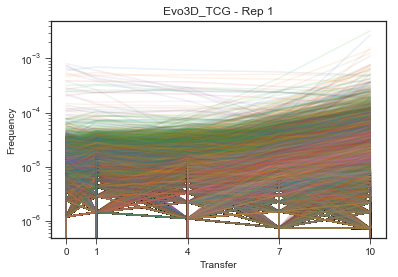

<Figure size 432x288 with 0 Axes>

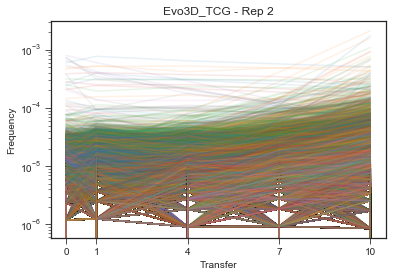

In [50]:
coverage_cutoff = 1e5

these_colors = [low_diversity_bc_colors[bc] for bc in cutoff_merged['low_diversity_BC'].values]

for rep in reps:
    exclude_times = []
    these_timepoints = [time for time in timepoints if time not in exclude_times]

    these_times = [f'{condition}_{rep}_{time}_count' for time in these_timepoints if time != 0]
    these_times = [f'{condition}_0_0_count'] + these_times

    these_counts = cutoff_merged[these_times].values
    

    these_freqs = these_counts/np.nansum(these_counts,axis=0)
    
    
    low_coverage = np.where(np.nansum(these_counts,axis=0)<coverage_cutoff)[0]
    
    these_freqs = np.delete(these_freqs,low_coverage,axis=1)
    these_times = np.delete(these_times,low_coverage)
    these_timepoints = np.delete(these_timepoints,low_coverage)
    
    plt.figure()
    fig,ax = plt.subplots()
    ax.set_prop_cycle(color=these_colors)
    plt.plot(these_timepoints,these_freqs.swapaxes(0,1)[:,:],alpha=0.1)
    plt.yscale('log')
    plt.xticks(these_timepoints,these_timepoints)
    plt.xlabel('Transfer')
    plt.ylabel('Frequency')
    plt.title(f'{condition} - Rep {rep}')
    plt.savefig(f'{condition}_{rep}_trajectories_lowdiversitycolor.pdf',bbox_inches='tight')
    plt.savefig(f'{condition}_{rep}_trajectories_lowdiversitycolor.png',dpi=200,bbox_inches='tight')

In [26]:
 color_cutoff*np.sum(list(low_diversity_bcs.values()))

1720.96

In [24]:
low_d_bcs_sorted

[('CCGCCAATCCCGAACCCCGTTTCGCC', 40061),
 ('GACAGAAAAGCCAAATGGATTTACCG', 29057),
 ('ATCAGAAGTTCGAATCAAATTACGAA', 26169),
 ('CCAACAAAAGGAAACGTATTTATTGA', 20166),
 ('TTAAAAATACAAAAAAAGATTTAAGG', 18545),
 ('AGAACAAAAACTAAACTCATTCATGG', 18219),
 ('ACTTAAAAAGCAAACATGATTATTCA', 7884),
 ('GTATTAAAATTAAAAATAATTGCACA', 6062),
 ('CTAGAAATCTCAAAAACTTTTGGCTG', 3067),
 ('CAGAAAAGCCATAACGCTATTTGAAA', 2684),
 ('CAAAGAACAACGAAAAACGTTCCCCT', 59),
 ('CGCCAATCCCGAACCCCGTTTCGCCG', 20),
 ('ACAGAAAAGCCAAATGGATTTACCGG', 19),
 ('TCAGAAGTTCGAATCAAATTACGAAG', 15),
 ('CAACAAAAGGAAACGTATTTATTGAG', 11),
 ('TAAAAATACAAAAAAAGATTTAAGGG', 9),
 ('GAACAAAAACTAAACTCATTCATGGG', 7),
 ('TCCTAAAACACAAACCCCATTCTGGG', 6),
 ('GCCAATCCCGAACCCCGTTTCGCCGG', 5),
 ('CTTAAAAAGCAAACATGATTATTCAG', 4),
 ('TATTAAAATTAAAAATAATTGCACAG', 4),
 ('AGAAAAGCCATAACGCTATTTGAAAG', 3),
 ('TAGAAATCTCAAAAACTTTTGGCTGG', 3),
 ('AGAAAAGCCAAATGGATTTACCGGGT', 2),
 ('CAGAAAAGCCAAATGGATTTACCGGG', 2),
 ('CGCTAAAGACATAATGTGGTTTGTTG', 2),
 ('TACCAAAAAGCTAAGTATTT